#Intro
Penney's game is a 2 player nontransitive game that can be done using a deck of cards or filling some coins. It is needed that each binary state is roughly 50-50

Two players start by guessing a string of binary states such as HHT or TTT  
and the goal is to see who's string appears first. Each string is known to everyone


When first published, Penney's game uses a string of 3 heads or tails. It has also been shown that red-black cards of a deck of cards is approximate to the probabilities

#Goal
This python notebooks seeks 
1. To generalize the game to a string of length n by utilizing markov chains. 
2. To generalize the game to include m players
3. To generalize the game to include multiple states

In [2]:
import numpy as np
import pandas as pd
import itertools as it
import math
from scipy.special import comb
from numpy.linalg import eig
import time

#Finding the probabilities

There are various methods to find the probabilities of a given set of unique sequences.

I will go over 3 methods:  
1. Markov Chains
2. Conway's Algorithm v1
3. Conway's Alorithm v2

Conway's algorithm returns the odds of each sequence, which is equivalent to the probability




## Markov Chains

A markov chain is represented by a transition matrix and because the game ends when one of the given patterns matches, these states have a 100% of ending on itself again, essentially ending the chain. (Replacing a row with a row from an identity matrix)

After swapping the rows, the matrix is meant to converge to infinity  
$\lim_{n \to \infty} M^n = P$, $M$ = transition matrix

After converging, we multiply with the stationary distribution of the unmodified transition matrix (which is uniform)

We can get the probabilities like this:  

(row vec of prob) = (row vec of uniform weights) * $P$


I will be using binary to represent the states where H=0 and T=1  

So 010 = HTH  


The matrix forms a diagonal matrix that resembles some stairsteps

In [3]:
#function to translate decimal to an arbritrary base

def baseb(n, b, length=None):
  #if type(n) is str:
  #  n = int(n)
  #e = n//b
  #q = n%b
  if n == 0:
    return '0'*length
  elif length is None:
    length = math.floor(1+math.log(n,b))

  new_base = ''
  while n!=0:
    r = n%b
    n=n//b
    
    new_base = str(r) + new_base
  lngth = len(new_base)
  if lngth < length:
    new_base = (length-lngth)*'0' + new_base
  return new_base

for i in range(10):
  print(baseb(i, 2, 4),'i =',i)

0000 i = 0
0001 i = 1
0010 i = 2
0011 i = 3
0100 i = 4
0101 i = 5
0110 i = 6
0111 i = 7
1000 i = 8
1001 i = 9


In the make_markov function, weights are considered, which are the weights the next flip will be.

So P(0) = 0.5, P(1) = 0.5 (base 2)  
or P(0) = 0.3, P(1) = 0.3, P(2) = 0.4 (base 3)

In [11]:
#generating markov matrix
def make_markov(mtx_length, base, weights = None):

  if weights == None:
    weights = np.ones(base)
  assert len(weights) == base, "Incorrect number of weights"

  #get identity/2
  step1 = np.eye(mtx_length//base, dtype=float)/base

  #interweave columns of identity/2 with itself
  step2 = np.zeros((step1.shape[0], step1.shape[0]*base))
  for i in range(base):
    step2[:,i::base] = step1*weights[i]/np.sum(weights) #interweaving

  #append a copy to the bottom
  step3 = step2.copy()
  for _ in range(base-1):
    step3 = np.append(step3,step2, axis=0)

  #done
  return step3


def get_states(mtx_length, base=2, length = None):
  #turns base to decimal

  #handling bad cases for given length
  min_digits = math.floor(1+math.log(mtx_length-1,base))
  if length is None or length < min_digits:
    length = min_digits

  states = {}
  for i in range(mtx_length):
    states[baseb(i, base, length)] = i
  return states


#length of subset of interest
length = 3
base = 2
mtx_length = base**length #side length of matrix

print(get_states(mtx_length,base,length))

matrix = make_markov(mtx_length, base, [1,2])

#displaying markov matrix in a dataframe
pd.DataFrame(matrix)

{'000': 0, '001': 1, '010': 2, '011': 3, '100': 4, '101': 5, '110': 6, '111': 7}


,0,1,2,3,4,5,6,7
0,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333
4,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333


A step in the matix has length = base and the stairs repeat = base

In [12]:

#function to get the probabilities when comparing 2 strings
def get_probabilities(players, base = 2, length=None):
  '''
  players = list of binary strings like [001, 111]
  base = numerical base, will be refered to as base
  length = length of string
  '''

  if length == None:
    length = len(players[0])
  assert all([ length == k for k in [len(i) for i in players] ]), "Given lengths does not all match"
  

  mtx_length = base**length

  #reference to change base to decimal and vice versa
  states = get_states(mtx_length, base, length) #base to decimal
  base_states = list(states.keys()) #decimal to base

  #representing given string into base and decimal (without duplicates)
  base_players = list(set(players)) 
  decimal_states = list(set([states[i] for i in players])) #decimal representation
  

  #modifying matrix with ending conditions
  #given states ends the markov chain and are represented as a row from the identity matrix
  I = np.eye(mtx_length,mtx_length, dtype = float)
  mtx_n = make_markov(mtx_length, base=base)
  for j in decimal_states: #replacing rows with identity matrix
    mtx_n[j,:] = I[j,:]

  #each state is equally likely
  start = np.ones((1,mtx_length))/mtx_length

  #we want the markov matrix to converge with repeat multiplications
  #15 is used as it seems converges happens around 8 multiplications
  n = 15
  M = mtx_n
  for _ in range(n):
    M = np.dot(M,M)


  #P = markov matrix
  #winnings = [0.125,...,0.125]*P^n, as n -> infinity
  #row vector of probabilities
  winnings = np.dot(start,M.round(5)).round(5) 

  #storing given strings into a dictionary with probabilities
  winning_dict = dict.fromkeys(base_players,0)
  for i in decimal_states:
    winning_dict[base_states[i]] = winnings[:,i][0]

  
  return winning_dict

base = 2
length = 3

start=time.time()
print(get_probabilities(['010', '111'], base, length))
print(f"Executed in {time.time()-start} seconds")

{'111': 0.18085, '010': 0.22341}
Executed in 0.005202293395996094 seconds


Here, the output of get_probabilities comes out with a dictionary with keys as the patterns and values as the probabilities

## Conway's Algorithm

John Conway developed a method to calculate the pairwise (only 2 player) probability.  

https://penneyante.weebly.com/conways-algorithm.html

Currently this algorithm works for any string length but only for binary and 2 players


In [14]:
def conway_alg(AB, base = 2):
  '''
  Calculates the pairwise odds for 2 players in binary
  '''
  length = len(AB[0])
  assert all([len(i)==length for i in AB]), "Given strings are not the same length"
  base_states = get_states(base**length, base) #binary to decimal

  odds = []
  for i in it.product(AB, repeat=2):
    base_odds = correlation(i[0], i[1])
    odds.append(base_states[base_odds])

  #odds = [AA, AB, BA, BB]
  A_then_B = odds[0]-odds[1]
  B_then_A = odds[3]-odds[2]
  return A_then_B, B_then_A

def correlation(A,B):
  #calculates conway correlation
  #AB is a list of lists, [A, B]
  n = len(A)
  pair = ""
  for i in range(1,n+1):
    d = [A[i+j-1] == B[j] for j in range(n-i+1)]
    if all(d):
      pair += '1'
    else:
      pair += '0'
  return pair


print(conway_alg(["000","100"]))
print(get_probabilities(["000","100","110"]))

(7, 1)
{'100': 0.175, '110': 0.23333, '000': 0.125}


## Conway's Algorithm v1

The original algorithm could not handle the generalization I was looking for, so here, I generalize it by holding the pairwise relations into a matrix.

To find the odds, replace a column with 1's and take the determinant. This will give the odds of the pattern represented by that column

This can handle any length pattern, any number of players, and any base

In [15]:

def conway_alg2(players, base = 2, length = None):
  '''
  conway's algorithm generalized for any length for any number of players in binary
  returns the odds of each string
  '''
  
  if length == None:
    length = len(players[0])
  assert all([len(i)==length for i in players]), "Given strings are not the same length"


  base_states = get_states(base**length, base)
  pairs = []
  for i in it.product(players, repeat=2):
    base_odds = correlation(i[0], i[1])
    pairs.append(base_states[base_odds])
  P = np.array(pairs).reshape(length,length).T

  odds = {}
  for i in range(length):
    Q = P.copy()
    Q[:,i] = np.ones(length)
    odds[players[i]] = np.linalg.det(Q).round(3)

  return odds


start=time.time()
print(conway_alg2(["000","100","110"]))
print(f"Executed in {time.time()-start} seconds")

{'000': 6.0, '100': 14.0, '110': 28.0}
Executed in 0.0011813640594482422 seconds


## Conway's algorithm v2

This method generalizes even more by considering an arbritary probability

P(0) = p, P(1) = q (base 2)

In [ ]:
'''
P(0) = p
P(1) = q

'''

A = ["000", "010", "001"] #patterns
l = min([len(a) for a in A]) #lengths


#symbolic calculation
B = []
for i in range(l):
  Bi = []
  for j in range(l):
    Bij = ""
    for k in range(1,l+1):
      left = A[i][:k]
      right = A[j][l-k:l+1]
      #print(left == right, left, right, A[i][k:l+1])
      if left == right:
        Ak = A[i][k:l+1].replace("0","p").replace("1","q")
        
        Bij += f"{Ak}s^{l-k} + "
    Bi.append(Bij)
  B.append(Bi)
print(B)

[['pps^2 + ps^1 + s^0 + ', 'pps^2 + ', ''], ['qps^2 + ', 'qps^2 + s^0 + ', 'ps^1 + '], ['pqs^2 + qs^1 + ', 'pqs^2 + ', 's^0 + ']]


In [ ]:
'''
Different variation of Conway's algorithm
Can handle any number of players, base, string length, and probability distribution

'''


A = ["000", "100", "211"] #patterns
base = 3
l = min([len(a) for a in A]) #string lengths
side = len(A) #matrix length

weights = np.array([1,1,1])
weights = weights/np.sum(weights)

pq = {}
for i in range(base): #string to number
  pq[str(i)] = weights[i]

start = time.time()
B = []
for i in range(side):
  Bi = []
  for j in range(side):
    Bij = 0
    for k in range(1,l+1):
      left = A[i][:k]
      right = A[j][l-k:l+1]
      if left == right:
        Ak = A[i][k:l+1]
        Bij += np.prod([pq[a] for a in Ak])
    Bi.append(Bij)
  B.append(Bi)

C = np.array(B).reshape(side,side)

for i in range(side):
 C[:,i] *= 1/np.prod([pq[a] for a in A[i]]) #matrix to get probabilities


prob = {}
for i in range(side):
  D = C.copy()
  D[:,i] = np.ones(side)
  prob[A[i]] = np.linalg.det(D).round(3)
print(prob)
print(f"Executed in {time.time()-start} seconds")

{'000': 441.0, '100': 936.0, '211': 1053.0}
Executed in 0.0016553401947021484 seconds


All the methods find the probabilities of a set of patterns, markov matrices and conway's algorithm.

All seem to roughly the same speed with conway's algorithm being marginally faster

#Getting the probabilities for each state

This is to see every possible combination. It becomes harder to visualize the comparison with more players as they add a dimension to the array holding it

Because I cant hold every possible pairing of num_players > 2 in a 2D matrix, this part wont be very deep



In [ ]:
#this attempt looks through a matrix of v
base = 2
length = 3
mtx_length = base**length

all_probablities = []
states = get_states(mtx_length, base = base)
base_states = list(states.keys())


for row in range(mtx_length):
  temp = []
  for col in range(mtx_length):
    temp.append(get_probabilities([base_states[col], base_states[row]], 
                                  base = base, 
                                  length = length))
  all_probablities.append(temp)

winning_probablities = pd.DataFrame(all_probablities)
winning_probablities

,0,1,2,3,4,5,6,7
0,{'000': 1.0},"{'001': 0.5, '000': 0.5}","{'000': 0.4, '010': 0.6}","{'000': 0.4, '011': 0.6}","{'000': 0.125, '100': 0.875}","{'000': 0.41667, '101': 0.58333}","{'000': 0.3, '110': 0.7}","{'000': 0.5, '111': 0.5}"
1,"{'000': 0.5, '001': 0.5}",{'001': 1.0},"{'001': 0.66667, '010': 0.33333}","{'001': 0.66667, '011': 0.33333}","{'001': 0.25, '100': 0.75}","{'001': 0.625, '101': 0.375}","{'001': 0.5, '110': 0.5}","{'001': 0.7, '111': 0.3}"
2,"{'000': 0.4, '010': 0.6}","{'001': 0.66667, '010': 0.33333}",{'010': 1.0},"{'011': 0.5, '010': 0.5}","{'100': 0.5, '010': 0.5}","{'010': 0.5, '101': 0.5}","{'110': 0.625, '010': 0.375}","{'010': 0.58333, '111': 0.41667}"
3,"{'000': 0.4, '011': 0.6}","{'001': 0.66667, '011': 0.33333}","{'011': 0.5, '010': 0.5}",{'011': 1.0},"{'100': 0.5, '011': 0.5}","{'011': 0.5, '101': 0.5}","{'011': 0.75, '110': 0.25}","{'011': 0.875, '111': 0.125}"
4,"{'000': 0.125, '100': 0.875}","{'001': 0.25, '100': 0.75}","{'100': 0.5, '010': 0.5}","{'100': 0.5, '011': 0.5}",{'100': 1.0},"{'100': 0.5, '101': 0.5}","{'100': 0.33333, '110': 0.66667}","{'100': 0.6, '111': 0.4}"
5,"{'000': 0.41667, '101': 0.58333}","{'001': 0.625, '101': 0.375}","{'101': 0.5, '010': 0.5}","{'011': 0.5, '101': 0.5}","{'100': 0.5, '101': 0.5}",{'101': 1.0},"{'110': 0.66667, '101': 0.33333}","{'101': 0.6, '111': 0.4}"
6,"{'000': 0.3, '110': 0.7}","{'001': 0.5, '110': 0.5}","{'110': 0.625, '010': 0.375}","{'110': 0.25, '011': 0.75}","{'100': 0.33333, '110': 0.66667}","{'110': 0.66667, '101': 0.33333}",{'110': 1.0},"{'110': 0.5, '111': 0.5}"
7,"{'000': 0.5, '111': 0.5}","{'001': 0.7, '111': 0.3}","{'010': 0.58333, '111': 0.41667}","{'011': 0.875, '111': 0.125}","{'100': 0.6, '111': 0.4}","{'101': 0.6, '111': 0.4}","{'110': 0.5, '111': 0.5}",{'111': 1.0}


In [ ]:

#listing every possible combination, but this is not sorted

num_players = 2
base=7
length=2
mtx_length = base**length

states = get_states(mtx_length, base=base)
base_states = list(states.keys())

#{state:[[other states, probabilities],...],...}
winning_state = dict.fromkeys(base_states,None)

#printing out every possible combination of probabilities
for j in it.combinations(base_states, num_players): #iterate through combinations
  prob = get_probabilities(j, base=base, length=length)
  print(prob)



#Finding the winning pattern

Now that we can compare various patterns, lets try to find the best pattern (given we know the opponent's patterns and every pattern is unique)

A dominant pattern is one that has probabily over 0.5, making it more likely to win than not. I'm not considering the case where the winning probability = max probabilty and less than 0.5.

This is found by only using combinations that includes the opponent patterns and finding which left over pattern has the biggest probability


The for loop searches through $\text{number of all possible states} \choose \text{number of players}$


In [ ]:
#Given list of opponent patterns, find the best pattern
#if there is no dominant pattern, then return next best or say none
def find_best(them, num_players=num_players, base=base, length=length, raw = False):

  states = get_states(base**length, base=base)
  base_states = list(states.keys())

  #if any opponent string length doesnt match picked string length, assert error
  assert all([ length == k for k in [len(i) for i in them] ]), "Opponent lengths does not match given length"

  # searching for possible states that only includes them
  not_them = []
  for j in it.combinations(base_states, num_players):
    them_in_comb = [i in j for i in them]
    if all(them_in_comb):
      prob = get_probabilities(j,base=base,length=length)

      #find states not included in them list and have prob over 0.5
      not_them += [(i,prob[i]) for i in prob if i not in them]
  
  #handling failed searches
  if not_them == []:
    return "None found"
  if raw:
    #return probabilities, no searching
    return not_them

  #finding the maximum probability
  best_prob = 0.0
  for me in not_them:
    if best_prob < me[1]:
      best_prob = me[1]

  #return states that match the best prob
  return [me for me in not_them if me[1] == best_prob]


num_players = 3
base=2
length=3
them = ["000","100"]

assert num_players-len(them) == 1, "Missing opponent patterns"
total_combinations = comb(base**length, num_players,exact=True)
print(f"Searching through {total_combinations} possible combinations")
#assert total_combinations < 100000, "Too many combinations"

find_best(them=them, num_players=num_players, base=base, length=length, raw=False)


Searching through 56 possible combinations


[('110', 0.58333)]

In [ ]:
get_probabilities(["0000","1000"],length=4)

{'0000': 0.0625, '1000': 0.9375}

The biggest limitation behind this code is the number of operations needed. Finding the probability requires multiplying a matrix 15 times to approximate the convergence.

The number of operations made is $\text{number of all possible states} \choose \text{number of players}$\*15\*(number of operations for matrix multiplication) operations = $n \choose \text{number of players}$\*15\*$(2n^3-n^2)$ operations where n = $base^{length}$

We can see that the number of operations grows very fast based on the total number of possible patterns


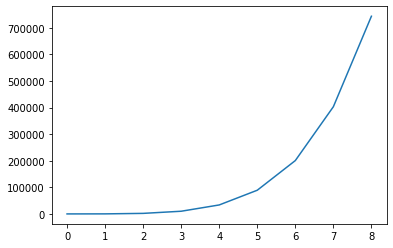

In [ ]:
import matplotlib.pyplot as plt

#counting the minimum amount of operations
def count_op(n, num_players=2):
  return comb(n,num_players,exact=True)*15*(2*n**3-n**2)

#count_op(2**3,2) #original game takes 
plotting = [count_op(i) for i in np.arange(1,10)]

plt.plot(plotting)
print("We can see that the number of operations grows very fast based on the total number of possible patterns")

#Verifying the math
The probabilities above are made theoretically, so it would be nice to see it it can be observed.


Here, I am performaing a simulation and counting when which pattern appears first

In [ ]:

def list2str(array, base=2):
  '''
  Translate the random walk into a sequence of decimal to encode the state
  Input:
  array = 2d matrix of only 0's and 1's
  '''
  decimals = []

  if len(array.shape) == 1:
    num_flips = array.shape[0]
    num_trials = 1
  else:
    num_flips = array.shape[1]
    num_trials = array.shape[0]

  for trial in range(num_trials):
    walk = []
    for flip in range(3,num_flips+1):
      subwalk = int(''.join(map(str,array[trial,(flip-3):flip])),base)
      #subwalk = '0b'+''.join(map(str,array[trial,(flip-3):flip]))
      walk.append(subwalk)
    decimals.append(walk)

  return np.array(decimals)

def check_str(players, array, base = 2, length=3):
  '''
  Input:
  players=list of binary strings
  array=decimal translating of random walk per subwalk
  string_length=length of string used for the game
  '''
  mtx_length = base**length
  states = get_states(mtx_length, base=base) #binary to decimal
  base_states = list(states.keys()) #decimal to binary
  unique_players = list(set(players)) #removes duplicates

  #make a dictionary from list of strings
  count = dict.fromkeys(unique_players,0)

  for row in range(array.shape[0]):
    for col in range(array.shape[1]):
      sub_state = base_states[array[row,col]] #decimal to binary
      if sub_state in unique_players:
        count[sub_state] += 1
        break
      else:
        assert 'Unknown Error'

  total = np.sum(list(count.values()))

  for i in unique_players:
    count[i] = count[i]/total
  return count


num_flips = 50
num_trials = 10000

base = 3
length = 3

walk = np.random.randint(0,base,(num_trials,num_flips))
compare = ['000','111', '012']
#assert all([ length == k for k in [len(i) for i in compare] ]), "Given lengths does not all match"

print(check_str(compare, 
                array = list2str(walk, base=base), 
                base = base, 
                length=length))

get_probabilities(compare, base=base,length=length)


{'000': 0.30037219595614123, '012': 0.3941253395030681, '111': 0.30550246454079066}


{'000': 0.3, '012': 0.4, '111': 0.3}

Testing out a few comparison seems to agree with theory, nice!

# Finding the stationary distribution
To find the probabilities, it is assumed each pattern is equally likely

Because we have a markov chain, I want to find a stationary distribution if it exists

This is just a tangent, it doesnt contribute to finding the probabilities


In [ ]:

def find_stationary(mtx):
  eig_val, eig_vec = eig(mtx.T)

  #find eigenvector associated with 1
  eig_vec1 = eig_vec[:,np.isclose(eig_val, 1)]
  eig_vec1 = eig_vec1[:,0]

  stationary = eig_vec1 / eig_vec1.sum()
  stationary = stationary.real

  return stationary

base = 3
length = 3
mtx_length = base**length

P = make_markov(base**length, base)

stationary = find_stationary(P)
print(stationary)

[0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]


The stationary distribution looks to always be the uniform distribution

In [ ]:
players = ["010","111", "110","000"]


states = get_states(mtx_length, base, length) #base to decimal
base_states = list(states.keys()) #decimal to base

#representing given string into base and decimal (without duplicates)
base_players = list(set(players)) 
decimal_states = list(set([states[i] for i in players])) #decimal representation


I = np.eye(mtx_length,mtx_length, dtype = float)
mtx_n = make_markov(mtx_length, base=base)
for j in decimal_states: #replacing rows with identity matrix
  mtx_n[j,:] = I[j,:]

stationary = find_stationary(mtx_n)

print(stationary)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


Finding the stationary distribution of a modified markov matrix returns which pattern is more likely to win